In [1]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse
import pandas as pd
import ast
parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=1)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=32)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=1.0)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha

skip
skip
skip


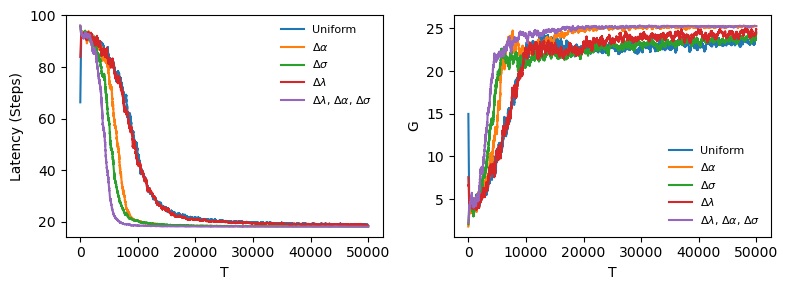

In [2]:
# plot example field 
ltypes = [0.0, 0.0001]
pcinit = 'uni'
f,ax = plt.subplots(1,2,figsize=(8,3))

window = 300
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
for llr in ltypes:
    for slr in ltypes:
        for alr in ltypes:

            try:
                [logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_{pcinit}_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
                
                name_components = []
                if llr > 0:
                    name_components.append(names_dict['llr'])
                if alr > 0:
                    name_components.append(names_dict['alr'])
                if slr > 0:
                    name_components.append(names_dict['slr'])
                name = ', '.join(name_components) if name_components else 'Uniform'
                

                ax[0].plot(moving_average(latencys, window),label=name)
                ax[0].set_xlabel('T')
                ax[0].set_ylabel('Latency (Steps)')

                ax[1].plot(moving_average(cum_rewards, window), label=name)
                ax[1].set_ylabel('G')
                ax[1].set_xlabel('T')
                            

            except FileNotFoundError: print('skip')

ax[0].legend(frameon=False, fontsize=8)
ax[1].legend(frameon=False, fontsize=8)

f.tight_layout()

f.savefig(f'./svgs/1D_perf_{pcinit}.svg')

In [3]:
def plot_density(logparams, trials, ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, color='k'):
    if ax is None:
        f,ax = plt.subplots()
    xs = np.linspace(-1,1,1001)

    for trial in trials:
        pcacts = predict_batch_placecell(logparams[trial], xs)
        dx = np.sum(pcacts,axis=1)
        ax.plot(xs, dx, label=f'T={trial}',color=color)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Density $d(x)$')
    ax.legend(frameon=False, fontsize=6)

def plot_pc(logparams, trial,title='', ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, ):
    if ax is None:
        f,ax = plt.subplots()

    xs = np.linspace(-1,1,1001)
    pcacts = predict_batch_placecell(logparams[trial], xs)

    # Get a colormap that transitions from purple to yellow
    cmap = cm.viridis
    num_curves = pcacts.shape[1]
    
    for i in range(num_curves):
        color = cmap(i / num_curves)
        ax.plot(xs, pcacts[:, i], color=color,zorder=1)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Tuning curves $\phi(x)$')
    ax.set_title(title)

    # ax.fill_betweenx(np.linspace(0,maxval), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Target')
    ax.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target',zorder=2)
    ax.axvline(startcoord[0],ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2,zorder=2)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k',zorder=2)
    # plt.legend(frameon=False, fontsize=6)

skip
skip
skip


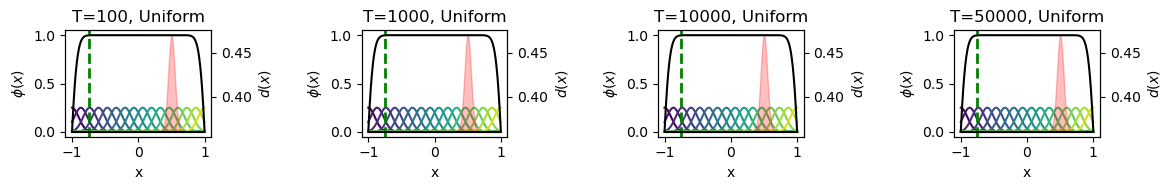

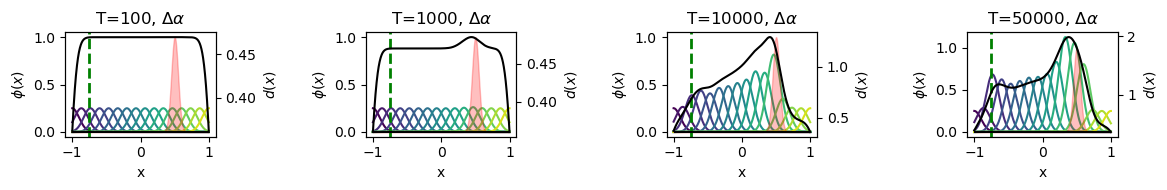

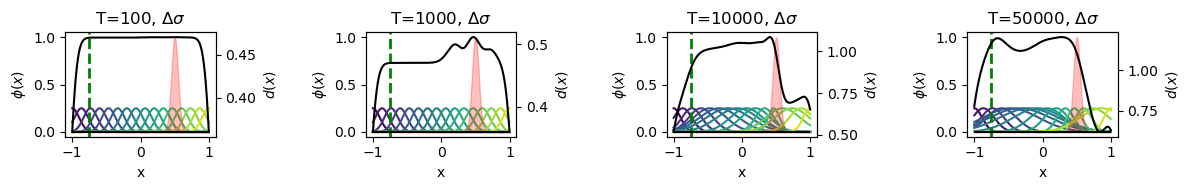

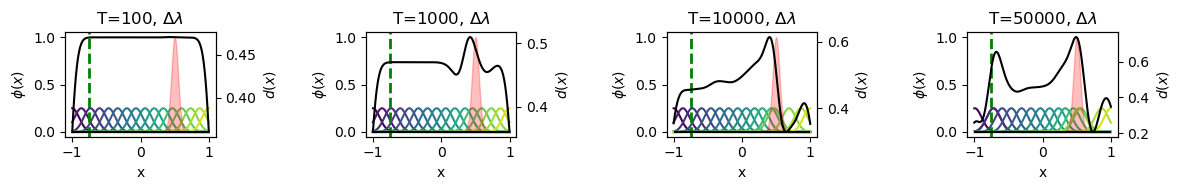

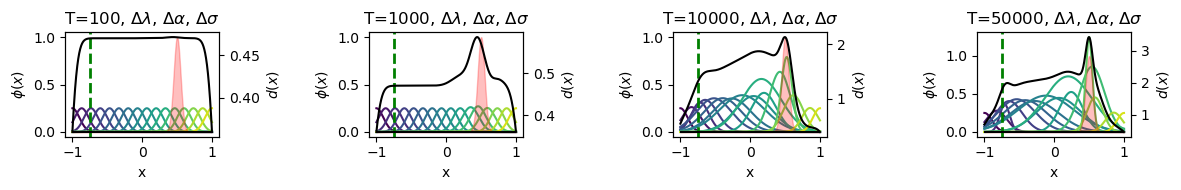

In [4]:
# plot example field 
ltypes = [0.0, 0.0001]
trials = [100, 1000, 10000, 50000]
pcinit = 'uni'
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
for llr in ltypes:
    for slr in ltypes:
        for alr in ltypes:

            try:
                [logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_{pcinit}_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
                
                name_components = []
                if llr > 0:
                    name_components.append(names_dict['llr'])
                if alr > 0:
                    name_components.append(names_dict['alr'])
                if slr > 0:
                    name_components.append(names_dict['slr'])
                name = ', '.join(name_components) if name_components else 'Uniform'
                
                f,ax = plt.subplots(1,4,figsize=(12,2))

                for t, trial in enumerate(trials):
                    plot_pc(logparams, trial=trial,ax=ax[t], goalsize=0.05)
                    ax[t].set_ylabel('$\phi(x)$')
                    ax[t].set_xlabel('x')
                    ax[t].set_title(f"T={trial}, {name}")
                    ax[t].legend().set_visible(False)

                    ax2 = ax[t].twinx()
                    plot_density(logparams, [trial], ax=ax2, goalsize=0.05)
                    ax2.set_ylabel('$d(x)$')
                    ax2.legend().set_visible(False)
                f.tight_layout()
                f.savefig(f'./svgs/1D_{pcinit}_{name}.svg')

            except FileNotFoundError: print('skip')



(3, 4, 10, 4, 50000) (3, 4, 10, 4, 50000) (3, 4, 10, 4, 1001) (3, 4, 10, 4)


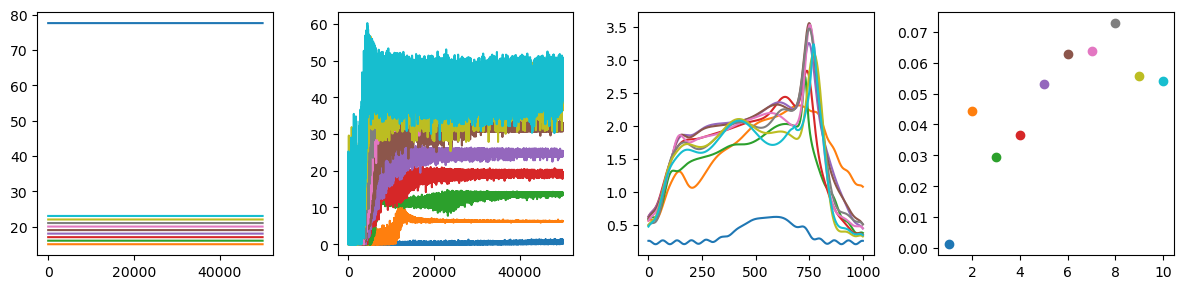

In [5]:
episodes = 50000
latencys, cumr, dxs, delta_dxrs = saveload(f"./comp_data/rmax_compile_{episodes}e", 1, 'load')
print(latencys.shape, cumr.shape, dxs.shape, delta_dxrs.shape)

npc_idx = 0
rsz_idx = 2
sigma_idx = 2

rmaxs = [1,2,3,4,5,6,7,8,9,10]

f,ax = plt.subplots(1,4,figsize=(12,3))
for r,rmax in enumerate(rmaxs):

    ax[0].plot(latencys[npc_idx, sigma_idx, r, rsz_idx], label=rmax)
    ax[1].plot(cumr[npc_idx, sigma_idx, r, rsz_idx], label=rmax)

    ax[2].plot(dxs[npc_idx, sigma_idx, r, rsz_idx], label=rmax)
    ax[3].scatter(rmax, delta_dxrs[npc_idx, sigma_idx, r, rsz_idx])

f.tight_layout()


(9, 4, 3, 4, 50000) (9, 4, 3, 4, 50000) (9, 4, 3, 4, 1001) (9, 4, 3, 4)


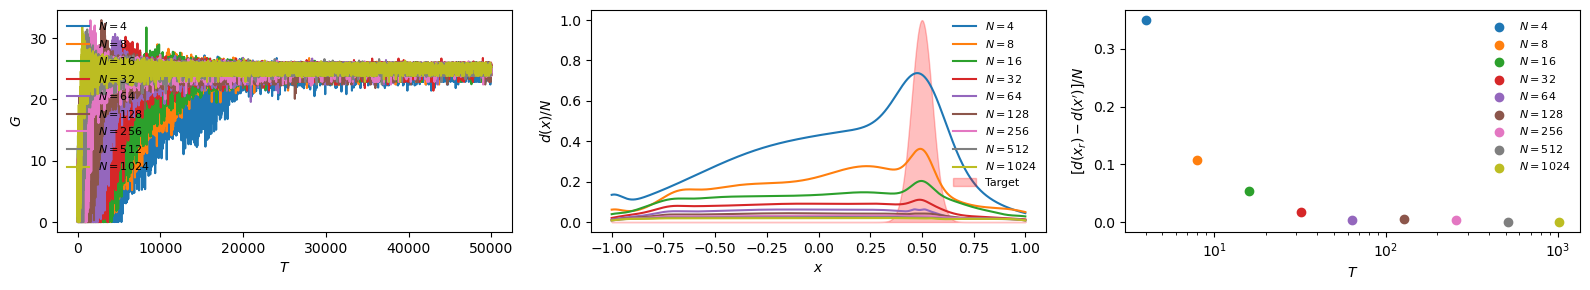

In [6]:
episodes = 50000
latencys, cumr, dxs, delta_dxrs = saveload(f"./comp_data/npc_compile_{episodes}e", 1, 'load')
print(latencys.shape, cumr.shape, dxs.shape, delta_dxrs.shape)

rmax_idx = 1
rsz_idx = 2
sigma_idx = 2
rszs = [0.01,0.025,0.05,0.1]
sigmas = [0.01,0.025,0.05,0.1]

npcs = [4,8,16,32,64,128,256,512, 1024]
xs = np.linspace(-1,1,1001)

f,ax = plt.subplots(1,3,figsize=(16,3))
for n,npc in enumerate(npcs):

    ax[0].plot(cumr[n, sigma_idx, rmax_idx, rsz_idx],label=f"$N={npc}$")

    ax[1].plot(xs, dxs[n, sigma_idx, rmax_idx, rsz_idx]/npc,label=f"$N={npc}$")
    ax[2].scatter(npc, delta_dxrs[n, sigma_idx, rmax_idx, rsz_idx],label=f"$N={npc}$")

for i in [0,2]:
    ax[i].legend(frameon=False, fontsize=8, loc='best')
    ax[i].set_xlabel('$T$')


ax[1].fill_between(xs, reward_func(xs, 0.5, rszs[rsz_idx]), color='red', alpha=0.25, label='Target')
ax[1].legend(frameon=False, fontsize=8, loc='best')
ax[1].set_xlabel('$x$')

# ax[0].set_ylabel('Latency')
ax[0].set_ylabel('$G$')
ax[1].set_ylabel('$d(x)/N$')
ax[2].set_ylabel('$[d(x_r)-d(x\')]/N$')
ax[2].set_xscale('log')
# ax[3].set_yscale('log')
f.tight_layout()


(9, 4, 3, 4, 50000) (9, 4, 3, 4, 50000) (9, 4, 3, 4, 1001) (9, 4, 3, 4)


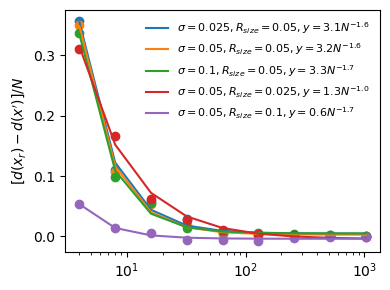

In [7]:
episodes = 50000
latencys, cumr, dxs, delta_dxrs = saveload(f"./comp_data/npc_compile_{episodes}e", 1, 'load')
print(latencys.shape, cumr.shape, dxs.shape, delta_dxrs.shape)

rmax_idx = 1
rmaxs = [1,5,10]
rszs = [0.01,0.025,0.05,0.1]
sigmas = [0.01,0.025,0.05,0.1]

npcs = [4,8,16,32,64,128,256,512, 1024]
xs = np.linspace(-1,1,1001)

f,ax = plt.subplots(figsize=(4,3))
for rsz_idx,sigma_idx  in zip([2,2,2, 1, 3], [1,2,3, 2,2]):

    y = delta_dxrs[:, sigma_idx, rmax_idx, rsz_idx]
    x = npcs
    ax.scatter(x, y)
    popt, func = fit_model(x, y, 'power')
    ax.plot(x, func(x, *popt), label=f'$\sigma={sigmas[sigma_idx]}, R_{{size}}={rszs[rsz_idx]}, y={popt[0]:.1f} N^{{{-popt[1]:.1f}}}$')

ax.legend(frameon=False, fontsize=8)


# ax[0].set_ylabel('Latency')
ax.set_ylabel('$[d(x_r)-d(x\')]/N$')
ax.set_xscale('log')
# ax.set_yscale('log')
f.tight_layout()

f.savefig('./svgs/dxr_npc.svg')



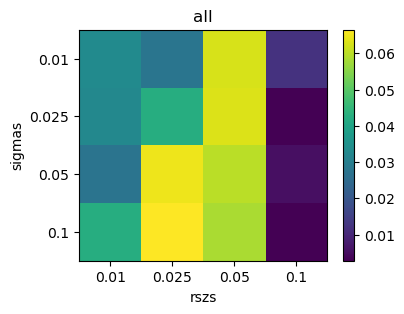

In [8]:
episodes = 50000
latencys, cumr, dxs, delta_dxrs = saveload(f"./comp_data/npc_compile_{episodes}e", 1, 'load')

rmax_idx = 1
data = delta_dxrs[:, :, rmax_idx, :]

f,ax = plt.subplots(figsize=(4,3))
im = ax.imshow(np.mean(delta_dxrs[:, :, rmax_idx, :],axis=0),aspect='auto')
plt.colorbar(im, ax=ax)

ax.set_xlabel('rszs')
ax.set_xticks(np.arange(4),rszs)
ax.set_ylabel('sigmas')
ax.set_yticks(np.arange(4),sigmas)
ax.set_title('all')
plt.show()

In [9]:
def normalize_values(x):
    maxval = np.max(x)
    minval = np.min(x)
    return (x-minval)/(maxval-minval)


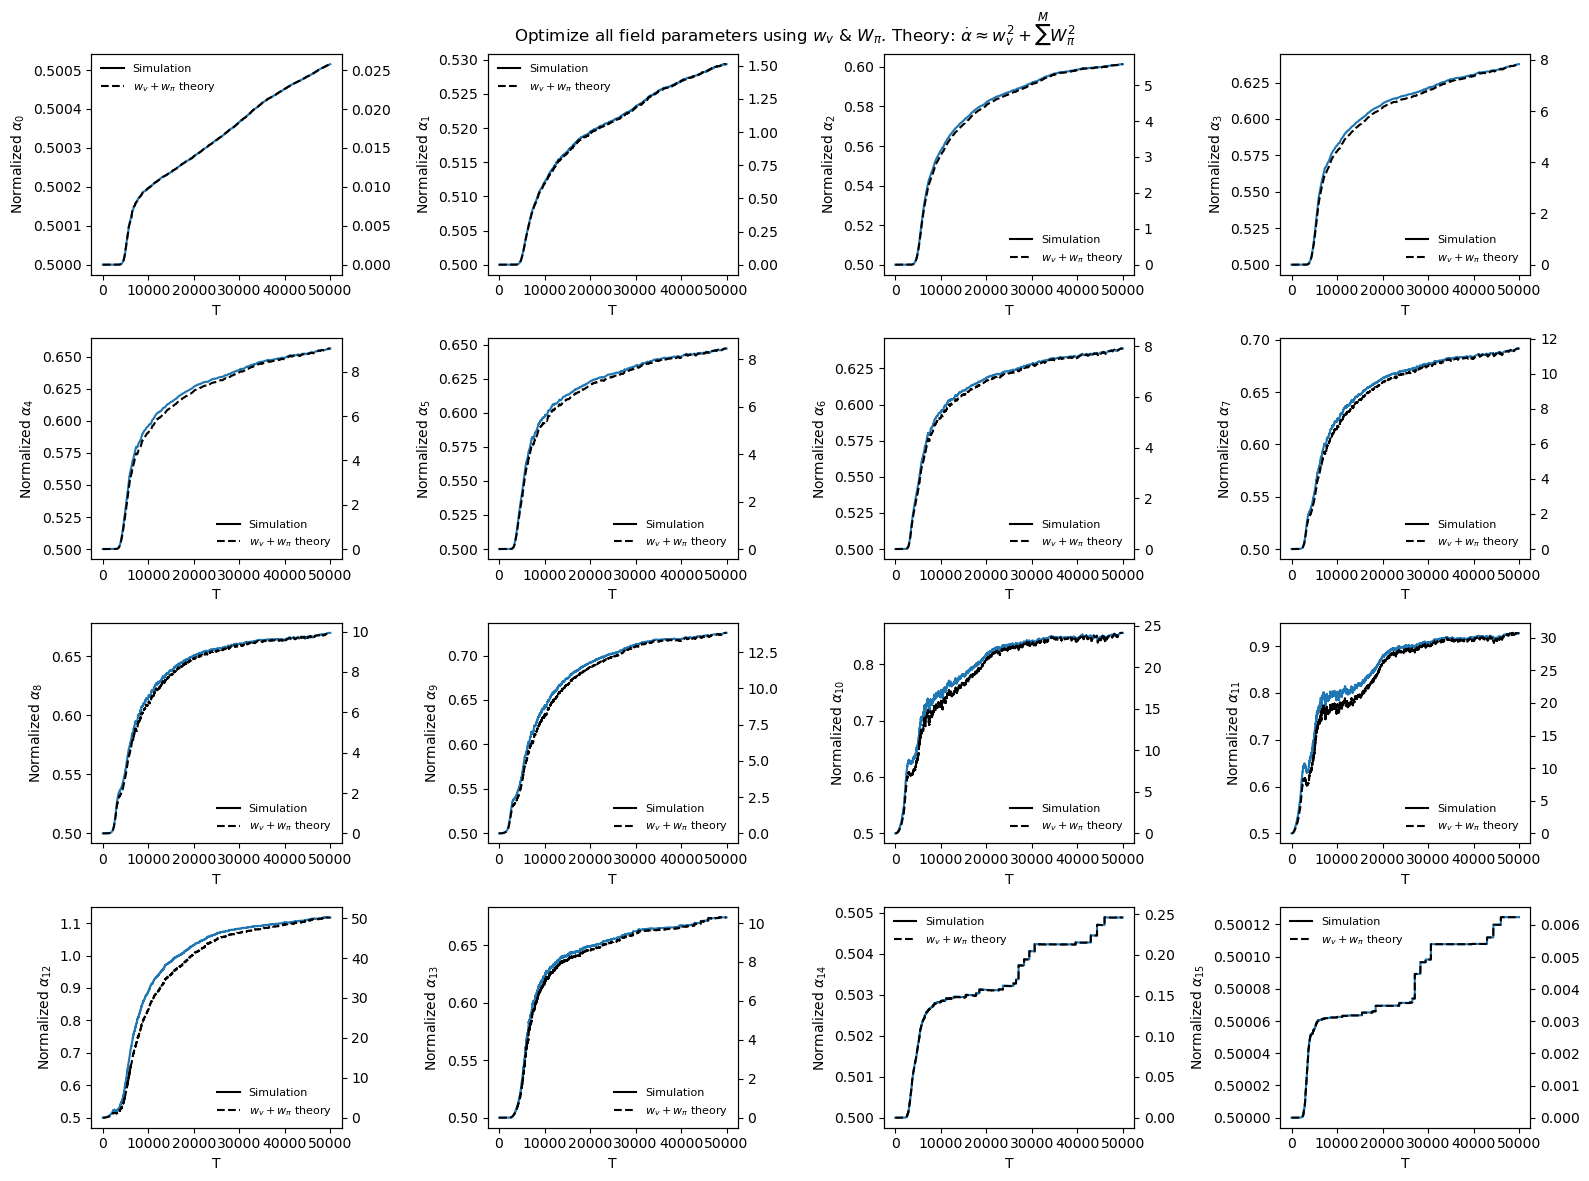

In [10]:
# theory vs simulation
llr = 0.0001
slr = 0.0001
alr = 0.0001
total_trials = 50000


[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
# [logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/wv_1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
N = 16

[lambdas, sigmas, alphas, policies, values] = get_param_changes(logparams, total_trials, stable_perf=0)


trial_max = 50000
f,ax = plt.subplots(4,4,figsize=(16,12))
f.suptitle('Optimize all field parameters using $w_v$ & $W_{\pi}$. Theory: $\dot\\alpha \\approx w_v^2 + \sum^M W_\pi^2$')

ax = ax.flatten()
for n in np.arange(N):
    sim = (alphas[:,n])
    half_theory = ((values[:,n,0]**2))
    theory = ((values[:,n,0]**2 + np.sum(policies[:,n]**2,axis=1)))

    ax[n].plot(np.arange(trial_max), sim)
    # ax.plot(np.arange(trial_max), half_theory, linestyle='--',color='gray')
    ax2 = ax[n].twinx()
    ax2.plot(np.arange(trial_max), theory, linestyle='--',color='k')

    ax[n].plot([],[],label='Simulation',color='k')
    # ax[n].plot([],[],linestyle='--', label='$w_v theory$',color='gray')
    ax[n].plot([],[], linestyle='--',label='$w_v + w_\pi$ theory',color='k')


    ax[n].set_ylabel(f'Normalized $\\alpha_{{{n}}}$')
    ax[n].set_xlabel('T')
    ax[n].legend(fontsize=8, frameon=False)

f.tight_layout()
f.savefig('./svgs/amplitude_theory.svg')


81.24725348475316
71.75628526618384
67.94700002393479


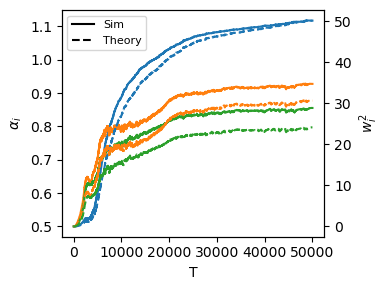

In [19]:
# theory vs simulation
llr = 0.0001
slr = 0.0001
alr = 0.0001
total_trials = 50000
num = 3

def normalize_values(x):
    return x

[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
# [logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/wv_1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")

[lambdas, sigmas, alphas, policies, values] = get_param_changes(logparams, total_trials, stable_perf=0)

trial_max = 50000

# f.suptitle('All field learning using $w_v$ & $W_{\pi}$. Theory: $\dot\\alpha \\approx w_v^2 + \sum^M W_\pi^2$')

variances = np.var(alphas, axis=0)
# Get indices of the top 10 variances
top_indices = np.argsort(variances)[-num:][::-1]

f,ax = plt.subplots(figsize=(4,3))
ax2 = ax.twinx()

for n in top_indices:
    sim = (alphas[:,n])
    half_theory = ((values[:,n,0]**2))
    theory = ((values[:,n,0]**2 + np.sum(policies[:,n]**2,axis=1)))

    print((np.max(theory)-np.min(theory))/(np.max(sim)-np.min(sim)))

    ax.plot(np.arange(trial_max), sim)
    ax.set_ylabel(f'$\\alpha_{{i}}$')
    ax.set_xlabel('T')

    # ax.plot(np.arange(trial_max), half_theory, linestyle='--',color='gray')

    ax2.plot(np.arange(trial_max), theory, linestyle='--')
    ax2.set_ylabel(f'$w_{{i}}^2$')


    # ax2 = ax.twinx()
    # ax2.plot(df, color='orange')


ax.plot([],[],label='Sim',color='k')
# ax.plot([],[],linestyle='--', label='$w_v theory$',color='gray')
ax.plot([],[], linestyle='--',label='Theory',color='k')
ax.legend(fontsize=8)
f.tight_layout()
f.savefig('./svgs/amp_theory.svg')


In [ ]:
slr,alr,llr = 0.0001,0.0001, 0.0001
pcinit = 'uni'
[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_{pcinit}_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")

f,score, drift = plot_analysis(logparams, latencys,cum_rewards, allcoords, 0, rsz=goalsize)